# Optimizers for Training Neural Networks

In [1]:
%load_ext autoreload
%autoreload 2

topics = ['SGD',
          'AdamW',
          'SCG',
          'Demonstrations on Training Weights for Neural Network with Single Hidden Layer']

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

In [2]:
%%writefile optimizers.py

import numpy as np
import copy
import math
import sys  # for sys.float_info.epsilon

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights
        self.error_trace = []
        self.best_val_error = None
        self.best_epoch = None
        self.best_weights = None 

Writing optimizers.py


# SGD

In [3]:
%%writefile -a optimizers.py

    def sgd(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, n_epochs=100, learning_rate=0.001, momentum=0, 
            weight_penalty=0,
            error_convert_f=None, error_convert_name='MSE', nesterov=False, verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        momentum : float
            Controls amount of previous weight update to add to current weight update, only for sgd
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        nestoerov: momentum factor for Nesterov momentum. If False, then uses zero for no momentum
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            # not initialized yet
            self.prev_update = 0
            if nesterov:
                self.all_weights_copy = np.zeros(self.all_weights.shape)
 
        # learning_rate /= (Xtrain.shape[0] * Ttrain.shape[1])
        
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            # Assume to be standardized already
            error = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
            grad = gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights

            val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

            if not nesterov:
                
                self.prev_update = learning_rate * grad + momentum * self.prev_update
                # Update all weights using -= to modify their values in-place.
                self.all_weights -= self.prev_update

            else:

                self.all_weights_copy[:] = self.all_weights 
                self.all_weights -= momentum * self.prev_update
                error = error_f(Xtrain, Ttrain)
                grad = gradient_f(Xtrain, Ttrain)
                self.prev_update = learning_rate * grad + momentum * self.prev_update
                self.all_weights[:] = self.all_weights_copy
                self.all_weights -= self.prev_update
                

            if error_convert_f:
                error = error_convert_f(error)
                val_error = error_convert_f(val_error)

            self.error_trace.append([error, val_error])

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'SGD: Epoch {epoch + 1} {error_convert_name}={error:.5f},{val_error:.5f}')

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()

        self.all_weights[:] = self.best_weights

        return self.error_trace

Appending to optimizers.py


# AdamW

Now we add the basic [Adaptive Moment Estimation (Adam)](https://ruder.io/optimizing-gradient-descent/index.html#adam).  

In [4]:
%%writefile -a optimizers.py

    ######################################################################
    #### adamw
    ######################################################################

    def adamw(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, n_epochs=100, learning_rate=0.001, weight_penalty=0,
              error_convert_f=None, error_convert_name='MSE', verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            shape = self.all_weights.shape
            # with multiple subsets (batches) of training data.
            self.mt = np.zeros(shape)
            self.vt = np.zeros(shape)
            self.sqrt = np.sqrt
                
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.beta1t = 1
            self.beta2t = 1

        # learning_rate /= (Xtrain.shape[0] * Ttrain.shape[1])

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
            grad = gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights

            val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= (alpha * m_hat / (self.sqrt(v_hat) + epsilon) + 
                                 weight_penalty * self.all_weights)
    
            if error_convert_f:
                error = error_convert_f(error)
                val_error = error_convert_f(val_error)

            self.error_trace.append([error, val_error])

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'AdamW: Epoch {epoch + 1} {error_convert_name}={error:.5f},{val_error:.5f}')

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()
                
        self.all_weights[:] = self.best_weights

        return self.error_trace

Appending to optimizers.py


# SCG 

And now the Scaled Conjugate Gradient, scg, algorithm.

In [5]:
%%writefile -a optimizers.py

    ######################################################################
    #### scg
    ######################################################################

    def scg(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, n_epochs=100, weight_penalty=0,
            error_convert_f=None, error_convert_name='MSE', verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            shape = self.all_weights.shape
            self.w_new = np.zeros(shape)
            self.w_temp = np.zeros(shape)
            self.g_new = np.zeros(shape)
            self.g_old = np.zeros(shape)
            self.g_smallstep = np.zeros(shape)
            self.search_dir = np.zeros(shape)

        sigma0 = 1.0e-6
        val_fold = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)
        fold = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
        error = fold
        val_error = val_fold
        self.g_new[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights
        self.g_old[:] = copy.deepcopy(self.g_new)
        self.search_dir[:] = -self.g_new
        success = True				# Force calculation of directional derivs.
        nsuccess = 0				# nsuccess counts number of successes.
        beta = 1.0e-6				# Initial scale parameter. Lambda in Moeller.
        betamin = 1.0e-15 			# Lower bound on scale.
        betamax = 1.0e20			# Upper bound on scale.
        nvars = len(self.all_weights)
        epoch = 1				# j counts number of epochs

        # Main optimization loop.
        while epoch <= n_epochs:

            # Calculate first and second directional derivatives.
            if success:
                mu = self.search_dir @ self.g_new
                if mu >= 0:
                    self.search_dir[:] = - self.g_new
                    mu = self.search_dir.T @ self.g_new
                kappa = self.search_dir.T @ self.search_dir
                if math.isnan(kappa):
                    print('kappa', kappa)

                if kappa < sys.float_info.epsilon:
                    return self.error_trace

                sigma = sigma0 / math.sqrt(kappa)

                self.w_temp[:] = self.all_weights
                self.all_weights += sigma * self.search_dir
                error_f(Xtrain, Ttrain)  + weight_penalty * np.sum(self.all_weights ** 2)
                self.g_smallstep[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights
                self.all_weights[:] = self.w_temp

                theta = self.search_dir @ (self.g_smallstep - self.g_new) / sigma
                if math.isnan(theta):
                    print('theta', theta, 'sigma', sigma, 'search_dir[0]', self.search_dir[0], 'g_smallstep[0]', self.g_smallstep[0])

            ## Increase effective curvature and evaluate step size alpha.

            delta = theta + beta * kappa
            # if math.isnan(scalarv(delta)):
            if math.isnan(delta):
                print('delta is NaN', 'theta', theta, 'beta', beta, 'kappa', kappa)
            elif delta <= 0:
                delta = beta * kappa
                beta = beta - theta / kappa

            if delta == 0:
                success = False
                fnow = fold
                val_fnow = val_fold
            else:
                alpha = -mu / delta
                ## Calculate the comparison ratio Delta
                self.w_temp[:] = self.all_weights
                self.all_weights += alpha * self.search_dir
                val_fnew = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)
                fnew = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
                Delta = 2 * (fnew - fold) / (alpha * mu)
                if not math.isnan(Delta) and Delta  >= 0:
                    success = True
                    nsuccess += 1
                    fnow = fnew
                    val_fnow = val_fnew
                else:
                    success = False
                    fnow = fold
                    val_fnow = val_fold
                    self.all_weights[:] = self.w_temp

            epochsPerPrint = math.ceil(n_epochs/10)
            if verbose and epoch % max(1, epochsPerPrint) == 0:
                print(f'SCG: Epoch {epoch} {error_convert_name}={error:.5f},{val_error:.5f}')

            if error_convert_f:
                val_error = error_convert_f(val_fnow)
                error = error_convert_f(fnow)
            else:
                error = fnow
                val_error = val_fnow
            self.error_trace.append([error, val_error])

            if success:

                fold = fnew
                val_fold = val_fnew
                self.g_old[:] = self.g_new
                self.g_new[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights

                # If the gradient is zero then we are done.
                gg = self.g_new @ self.g_new  # dot(gradnew, gradnew)
                if gg == 0:
                    return self.error_trace

            if math.isnan(Delta) or Delta < 0.25:
                beta = min(4.0 * beta, betamax)
            elif Delta > 0.75:
                beta = max(0.5 * beta, betamin)

            # Update search direction using Polak-Ribiere formula, or re-start
            # in direction of negative gradient after nparams steps.
            if nsuccess == nvars:
                self.search_dir[:] = -self.g_new
                nsuccess = 0
            elif success:
                gamma = (self.g_old - self.g_new) @ (self.g_new / mu)
                #self.search_dir[:] = gamma * self.search_dir - self.g_new
                self.search_dir *= gamma
                self.search_dir -= self.g_new

            epoch += 1

            # If we get here, then we haven't terminated in the given number of
            # epochs.

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()

        self.all_weights[:] = self.best_weights

        return self.error_trace

Appending to optimizers.py


# Demonstration of Training Weights for Neural Network with Single Hidden Layer

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt

In [7]:
######################################################################
# Make date and partition randomly into training, validation, and testing

Xtrain = np.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = np.sin(Xtrain) * np.sin(Xtrain * 5)
    
Xval = Xtrain * 1.1  # + 0.2
Tval = Ttrain + 0.2 * Xtrain
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain # + np.random.uniform(-0.05, 0.05, Ttrain.shape) 
        
n_samples, n_inputs = Xtrain.shape
n_outputs = Ttrain.shape[1]

In [8]:
######################################################################
# Make weight and gradient one-dimensional vectors and matrix views
# Neural net has only one hidden layer.

def make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs):
    
    # Weight vector and matrix views
        
    Vshape = (1 + n_inputs, n_hiddens)
    Wshape = (1 + n_hiddens, n_outputs)
    
    n_V = np.prod(Vshape)
    n_W = np.prod(Wshape)
    n_weights = n_V + n_W
    all_weights = np.random.uniform(-1, 1, n_weights)
    V = all_weights[:n_V].reshape(Vshape)
    V /= np.sqrt(Vshape[0])
    W = all_weights[n_V:].reshape(Wshape)
    W /= np.sqrt(Wshape[0])
    W[:] = 0.0  # set output layer weights to zeros
    
    # Gradient vector and matrix views
    
    all_gradients = np.zeros_like(all_weights)
    grad_V = all_gradients[:n_V].reshape(Vshape)
    grad_W = all_gradients[n_V:].reshape(Wshape) 

    return all_weights, V, W, all_gradients, grad_V, grad_W

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, 10, n_outputs)

In [9]:
all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
grad_W

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [61]:
######################################################################
# Neural network functions
    
def rmse_unstandardized(T, Y, Tstds):
    return np.sqrt(np.mean((T - Y)**2, axis=0))[0]

def add_ones(A):
    return np.insert(A, 0, 1, axis=1)

# Function to be minimized by optimizer method, mean squared error
def error_f(X, T):
    global Z, Y
    # forward pass
    Z = np.tanh(add_ones(X) @ V)
    Y = add_ones(Z) @ W
    mean_sq_error = np.mean((T - Y) ** 2)
    return mean_sq_error

# Gradient of function to be minimized for use by optimizer method
def gradient_f(X, T):
    global Z, Y, grad_W, grad_V, all_gradients   # remove ones that aren't changed in this function
    n_samples = X.shape[0]
    n_outputs = T.shape[1]
    Dw = -(T - Y) / (n_samples * n_outputs)
    Dv = Dw @ W[1:, :].T * (1 - Z**2)
    grad_W[:] = add_ones(Z).T @ Dw
    grad_V[:] = add_ones(X).T @ Dv
    return all_gradients

# Apply network to data X
def use(X):
    X = (X - Xmeans) / Xstds
    Z = np.tanh(add_ones(X) @ V)
    Y = add_ones(Z) @ W
    return Y * Tstds + Tmeans

In [62]:
######################################################################
# Standardize data
    
Xmeans = Xtrain.mean(axis=0)
Xstds = Xtrain.std(axis=0)
Tmeans = Ttrain.mean(axis=0)
Tstds = Ttrain.std(axis=0)

XtrainS = (Xtrain - Xmeans) / Xstds
TtrainS = (Ttrain - Tmeans) / Tstds
XvalS = (Xval - Xmeans) / Xstds
TvalS = (Tval - Tmeans) / Tstds
# XtestS = (Xtest - Xmeans) / Xstds
# TtestS = (Ttest - Tmeans) / Tstds

In [63]:
def plot_results(error_trace, optimizer, method):
    plt.subplot(2, 1, 1)
    plt.plot(error_trace)
    plt.axvline(optimizer.best_epoch, ymin=0, ymax=1, color='black', lw=4, alpha=0.2)
    
    plt.subplot(2, 1, 2)
    plt.plot(Xtrain, Ttrain, 'b.', label='Ttrain')
    plt.plot(Xtrain, use(Xtrain), 'b-', label='Ytrain')
    
    plt.plot(Xval, Tval, 'r.', label='Tval')
    plt.plot(Xtest, Ttest, 'c.', label='Ttest')
    plt.legend()
    
    title = f'{method}: RMSE Train {rmse_unstandardized(Ttrain, use(Xtrain), Tstds):.2f}'
    title += f' Val {rmse_unstandardized(Tval, use(Xval), Tstds):.2f}'
    title += f' Test {rmse_unstandardized(Ttest, use(Xtest), Tstds):.2f}'
    title += f' Best Epoch {optimizer.best_epoch:,}'  # what is this comma doing ?
    plt.title(title)
    plt.tight_layout();

n_hiddens=20
SGD: Epoch 10000 MSE=0.91240,1.10764
SGD: Epoch 20000 MSE=0.77046,0.93179
SGD: Epoch 30000 MSE=0.36154,0.57266
SGD: Epoch 40000 MSE=0.17546,0.48546
SGD: Epoch 50000 MSE=0.09065,0.51332
SGD: Epoch 60000 MSE=0.04721,0.61166
SGD: Epoch 70000 MSE=0.03120,0.68572
SGD: Epoch 80000 MSE=0.02084,0.71597
SGD: Epoch 90000 MSE=0.01320,0.73130
SGD: Epoch 100000 MSE=0.00878,0.74450


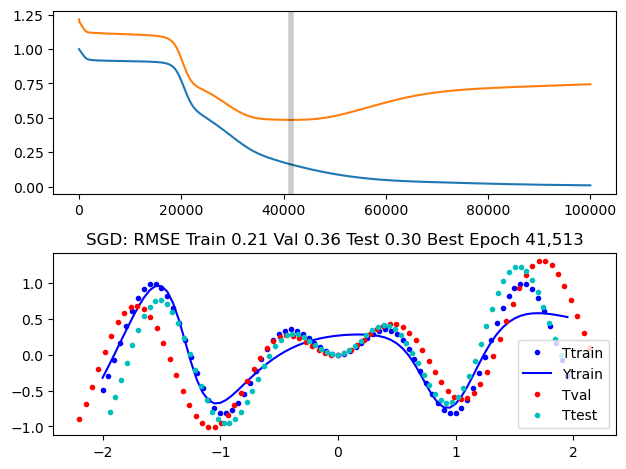

In [71]:
n_hiddens = 20
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)

n_epochs = 100_000
learning_rate = 0.02
momentum = 0.
weight_penalty = 0.0
error_trace = optimizer.sgd(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, learning_rate=learning_rate,
                            momentum=momentum, weight_penalty=weight_penalty,
                            verbose=True)

plot_results(error_trace, optimizer, 'SGD')

n_hiddens=20
AdamW: Epoch 500 MSE=0.00157,0.76706
AdamW: Epoch 1000 MSE=0.00044,0.83240
AdamW: Epoch 1500 MSE=0.00033,0.83447
AdamW: Epoch 2000 MSE=0.00025,0.83191
AdamW: Epoch 2500 MSE=0.00020,0.82664
AdamW: Epoch 3000 MSE=0.00016,0.82221
AdamW: Epoch 3500 MSE=0.00017,0.81368
AdamW: Epoch 4000 MSE=0.00061,0.82413
AdamW: Epoch 4500 MSE=0.00070,0.82037
AdamW: Epoch 5000 MSE=0.00008,0.81040


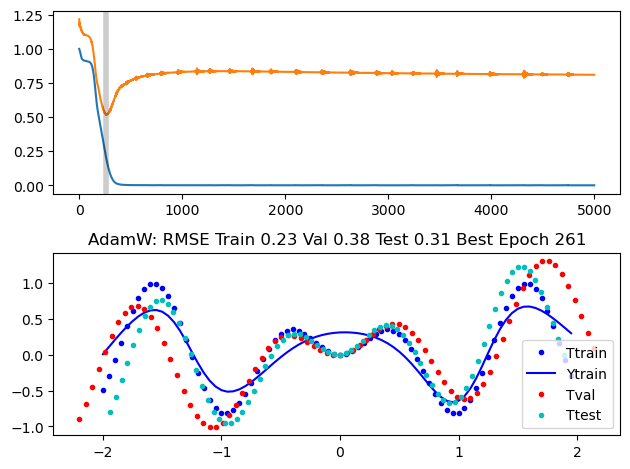

In [72]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 5_000
learning_rate = 0.01
weight_penalty = 0.0
error_trace = optimizer.adamw(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                              n_epochs=n_epochs, learning_rate=learning_rate,
                              weight_penalty=weight_penalty,
                              verbose=True)
plot_results(error_trace, optimizer, 'AdamW')

n_hiddens=20
SCG: Epoch 500 MSE=0.00181,0.85502
SCG: Epoch 1000 MSE=0.00042,0.81210
SCG: Epoch 1500 MSE=0.00022,0.80095
SCG: Epoch 2000 MSE=0.00010,0.78936
SCG: Epoch 2500 MSE=0.00003,0.77115
SCG: Epoch 3000 MSE=0.00002,0.75831
SCG: Epoch 3500 MSE=0.00001,0.75109
SCG: Epoch 4000 MSE=0.00001,0.74785
SCG: Epoch 4500 MSE=0.00001,0.74457
SCG: Epoch 5000 MSE=0.00001,0.74364


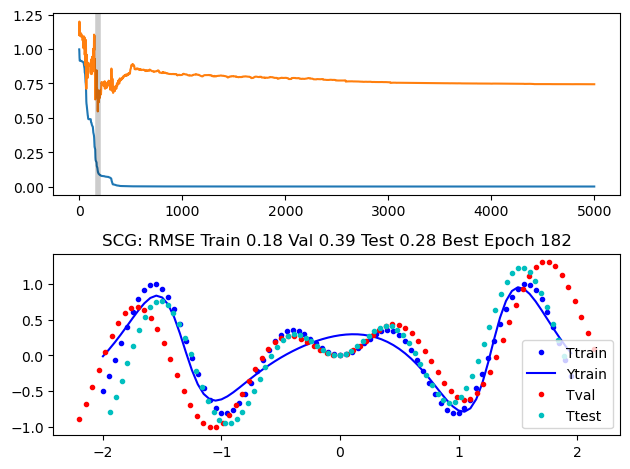

In [73]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 5_000
weight_penalty = 0.0
error_trace = optimizer.scg(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, 
                            weight_penalty=weight_penalty,
                            verbose=True) 
plot_results(error_trace, optimizer, 'SCG')

n_hiddens=20
SCG: Epoch 7000 MSE=0.00000,0.75053
SCG: Epoch 14000 MSE=0.00000,0.75005
SCG: Epoch 21000 MSE=0.00000,0.74961
SCG: Epoch 28000 MSE=0.00000,0.74934
SCG: Epoch 35000 MSE=0.00000,0.74908
SCG: Epoch 42000 MSE=0.00000,0.74892
SCG: Epoch 49000 MSE=0.00000,0.74875
SCG: Epoch 56000 MSE=0.00000,0.74861
SCG: Epoch 63000 MSE=0.00000,0.74848
SCG: Epoch 70000 MSE=0.00000,0.74832


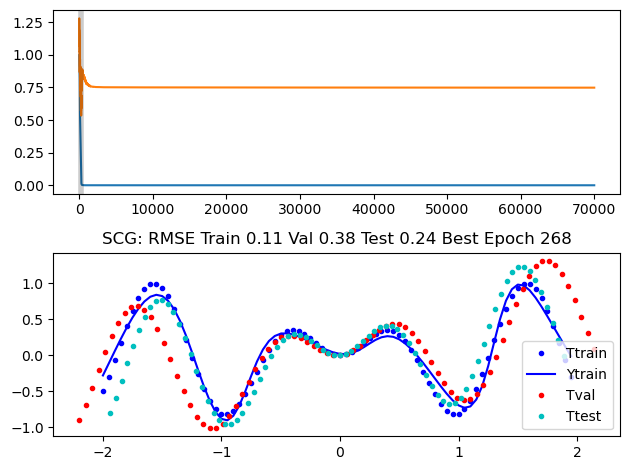

In [74]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 70_000
weight_penalty = 0.0
error_trace = optimizer.scg(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, 
                            weight_penalty=weight_penalty,
                            verbose=True) 
plot_results(error_trace, optimizer, 'SCG')